In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "6" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "6" # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6

In [2]:
from matplotlib import pyplot as plt

import torch

from omegaconf import OmegaConf
from ase.visualize.plot import plot_atoms
from ase import Atoms
from schnetpack import properties
import schnetpack.transform as trn
from schnetpack.datasets import QM9
from schnetpack.interfaces import SpkCalculator
from schnetpack.interfaces.ase_interface import AtomsConverter
from tqdm import tqdm
import ase
import ase.io
import ase.db
import numpy as np
from ase.optimize.lbfgs import LBFGS

from morered.datasets import QM9Filtered, QM7X
from morered.noise_schedules import PolynomialSchedule
from morered.processes import VPGaussianDDPM
from morered.utils import scatter_mean, check_validity, generate_bonds_data, batch_center_systems
from morered.sampling import DDPM, MoreRedJT, MoreRedAS, MoreRedITP
from morered.utils import rmsd
from ase.visualize import view

# Helper functions

In [3]:
def plot_list_molecules(mol_list, plot=True):
    n_cols = 8
    n_rows = len(mol_list) // n_cols
    if len(mol_list) % n_cols != 0:
        n_rows += 1

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3.5 * n_rows))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        if i >= len(mol_list):
            ax.axis("off")
            continue
        
        plot_atoms(mol_list[i], ax, rotation="-0x,0y,0z")
        ax.axis("off")

    if plot:
        plt.tight_layout()
        plt.show()

    return  axs

In [4]:
def plot_batch_molecules(batch):
    n_cols = 8
    n_rows = len(batch[properties.idx_m].unique()) // n_cols
    n_rows += 1 if len(batch[properties.idx_m].unique()) % n_cols != 0 else 0

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3.5 * n_rows))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        if i >= len(batch[properties.idx_m].unique()):
            ax.axis("off")
            continue
        mask = batch[properties.idx_m] == i
        mol = Atoms(numbers=batch[properties.Z][mask], positions=batch[properties.R][mask])

        plot_atoms(mol, ax)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Load molecules

In [6]:
dir_path = "/home/twopaisquared/Desktop/projects/UltraRed/experiments/diffusion/data/dichlorethene_rotamers"

In [7]:
# read .xyz files in the dir
files = [f for f in os.listdir(dir_path) if f.endswith(".xyz")]
print(files)

['rotamer_11.xyz', 'min_1.xyz', 'rotamer_19.xyz', 'rotamer_12.xyz', 'rotamer_15.xyz', 'rotamer_1.xyz', 'rotamer_3.xyz', 'rotamer_16.xyz', 'rotamer_20.xyz', 'rotamer_9.xyz', 'rotamer_17.xyz', 'min_0.xyz', 'rotamer_13.xyz', 'rotamer_4.xyz', 'rotamer_18.xyz', 'rotamer_10.xyz', 'rotamer_8.xyz', 'rotamer_7.xyz', 'rotamer_2.xyz', 'rotamer_5.xyz', 'rotamer_14.xyz', 'rotamer_6.xyz']


In [8]:
mols = []
orig_conformers = []
for f in files:
    mol = ase.io.read(os.path.join(dir_path, f))
    if "min" in f:
        orig_conformers.append(mol)
    else:
        mols.append(mol)

# Data Analysis

In [9]:
# Compute rmsd to original conformer
rmsds_0 = [rmsd(orig_conformers[0], mol, keep_original=True) for mol in mols]
rmsds_1 = [rmsd(orig_conformers[1], mol, keep_original=True) for mol in mols]
rmsds = np.min([rmsds_0, rmsds_1], axis=0)

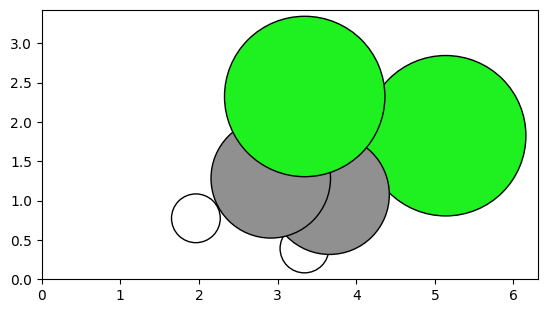

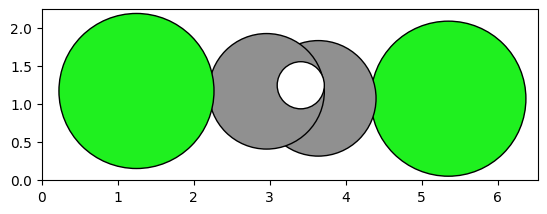

In [10]:
plot_atoms(orig_conformers[0], rotation="-0x,0y,0z")
plt.show()
plot_atoms(orig_conformers[1], rotation="-0x,0y,0z")
plt.show()

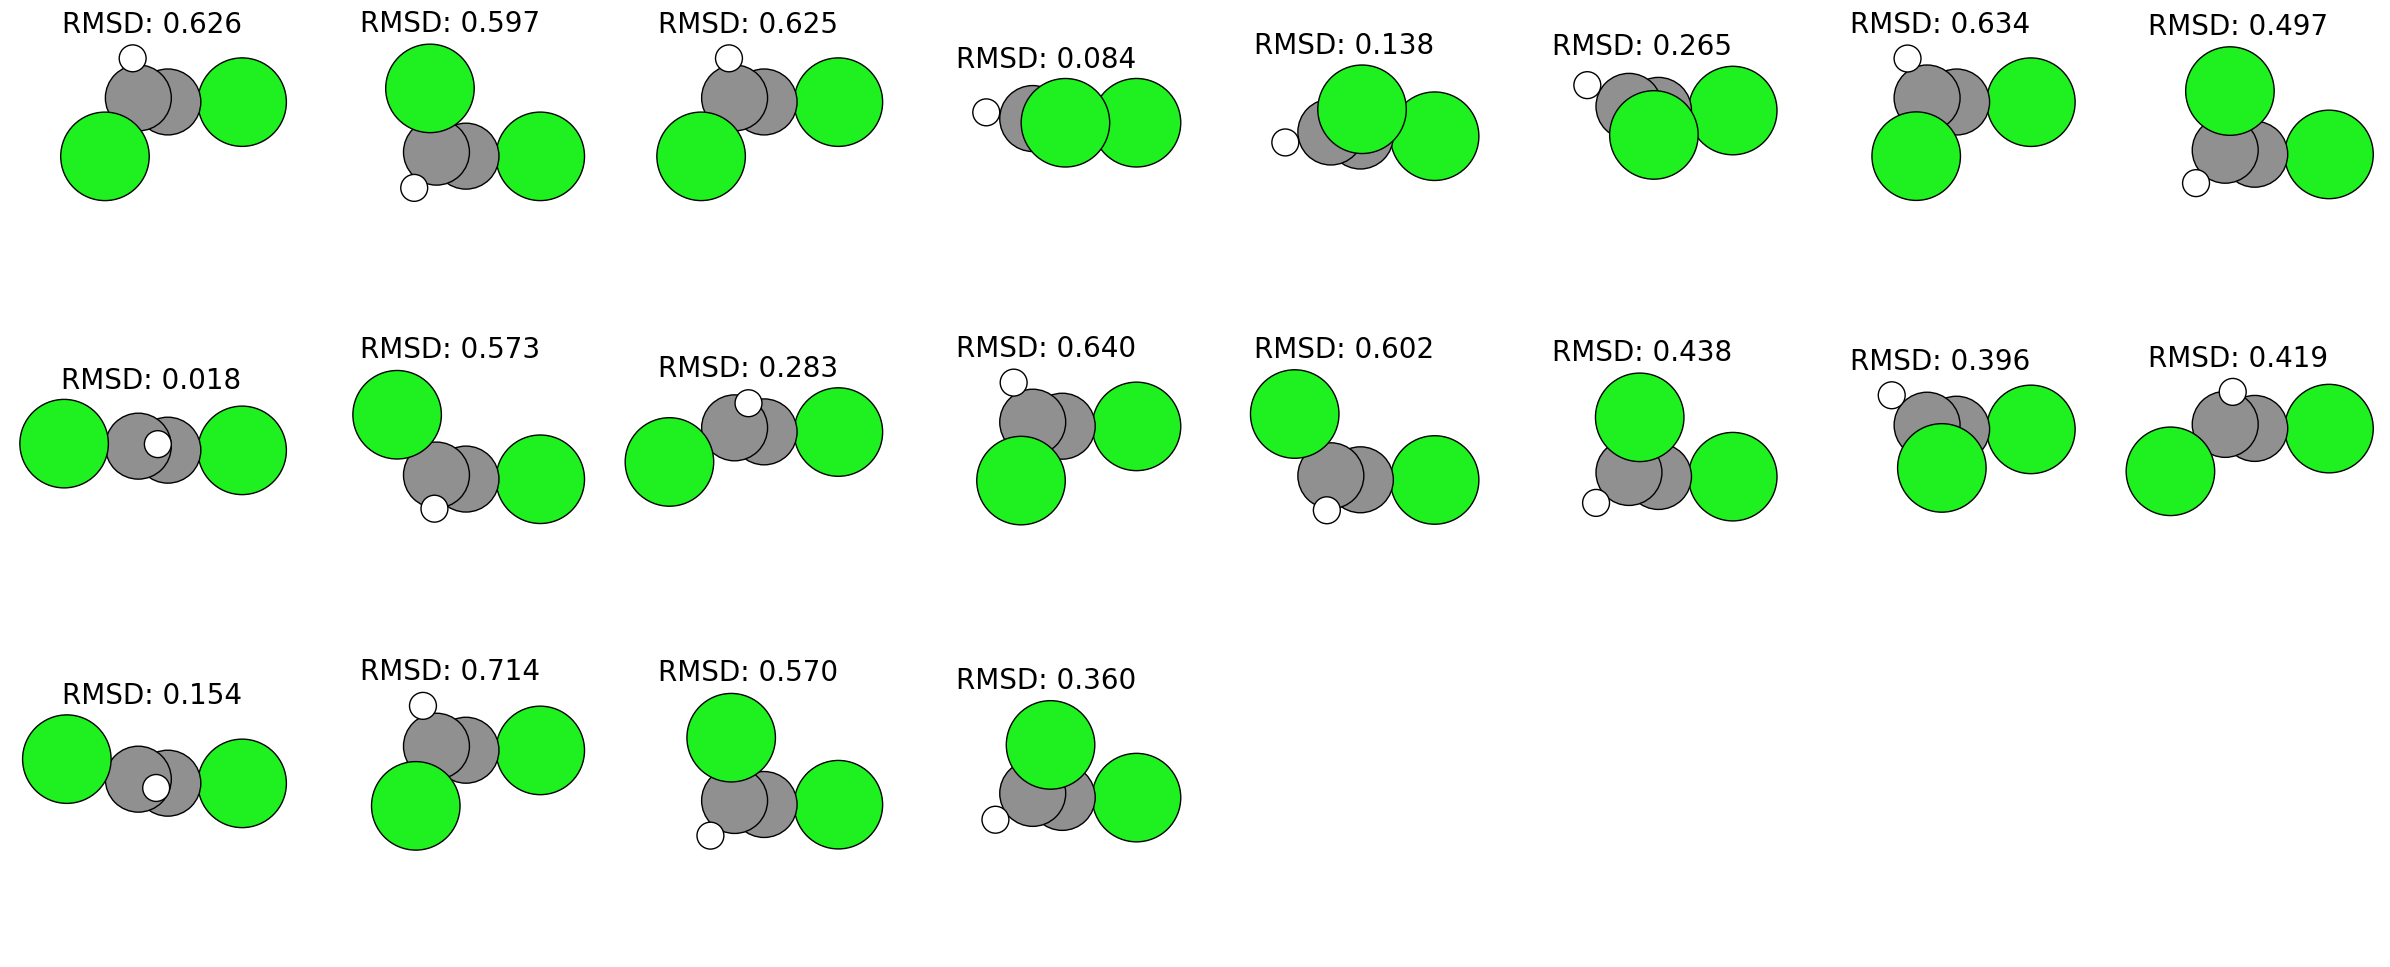

In [11]:
axs = plot_list_molecules(mols, plot=False)

for i in range(len(mols)):
    axs[i].set_title(f"RMSD: {rmsds[i]:.3f}", fontsize=20)

plt.tight_layout()
plt.show()

# Load model

In [12]:
model_path = "/home/twopaisquared/Desktop/projects/MoreRed/experiments/final/runs/qm7x_vp_gauss_ddpm_ac51f32e-f289-11ee-b783-7e8ae1cdf891/best_model"
time_pred_path = "/home/twopaisquared/Desktop/projects/MoreRed/experiments/final/runs/qm7x_vp_gauss_time_predictor_b112ee72-f289-11ee-8d72-7e8ae1cdf891/best_model"

In [13]:
denoiser = torch.load(model_path, map_location="cpu")

In [14]:
time_predictor = torch.load(time_pred_path, map_location="cpu")

# Define denoiser/sampler process

In [15]:
# define the noise schedule
noise_schedule = PolynomialSchedule(T=1000, s=1e-5, dtype=torch.float64, variance_type="lower_bound")

# define the forward diffusion process
diff_proc = VPGaussianDDPM(noise_schedule, noise_key="eps", invariant=True, dtype=torch.float64)

In [15]:
sampler = DDPM(
    diff_proc,
    denoiser,
    time_key="t",
    noise_pred_key="eps_pred",
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True,
)

In [16]:
sampler = MoreRedJT(
    diff_proc,
    denoiser,
    noise_pred_key="eps_pred",
    time_key="t",
    time_pred_key="t_pred",
    convergence_step=0,
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True
)

In [17]:
sampler = MoreRedAS(
    diff_proc,
    denoiser,
    time_predictor,
    noise_pred_key="eps_pred",
    time_key="t",
    time_pred_key="t_pred",
    convergence_step=0,
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True
)

In [18]:
sampler = MoreRedITP(
    diff_proc,
    denoiser,
    time_predictor,
    noise_pred_key="eps_pred",
    time_key="t",
    time_pred_key="t_pred",
    convergence_step=0,
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True
)

# Check training data

In [19]:
tr ,val, ts = np.load("/home/twopaisquared/Desktop/projects/UltraRed/experiments/diffusion/data/qm7x_splits/split_2/splits_qm7x_eq.npz").values()

In [ ]:
len(tr) + len(val) + len(ts), np.union1d(np.union1d(tr, val), ts).max()

In [ ]:
conn = ase.db.connect("/home/twopaisquared/Desktop/projects/UltraRed/experiments/diffusion/data/qm7x.db")

#random_ids = np.random.choice(conn.count()+1, 16)
numbers = []
for idx in tqdm(tr):
    row = conn.get(id=int(idx)+1)
    numbers.append(row.numbers)
    assert row.data["rmsd"] < 1e-4

In [ ]:
atoms_types = np.unique(np.concatenate(numbers).flatten())
atoms_types

In [ ]:
sum([1 if 17 in nums else 0 for nums in numbers]) / len(numbers), len(numbers)

# Analyse atom types

In [21]:
conn = ase.db.connect("/home/twopaisquared/Desktop/projects/UltraRed/experiments/diffusion/data/qm7x.db")

#random_ids = np.random.choice(conn.count()+1, 16) 
numbers = []

for row in tqdm(conn.select()):
    numbers.append(row.numbers)

4003337it [27:43, 2406.18it/s]


In [28]:
# save numbers as pkl:
import pickle

with open("files/qm7x_numbers.pkl", "wb") as f:
    pickle.dump(numbers, f)

In [29]:
atoms_types = np.unique(np.concatenate(numbers))
atoms_types

array([ 1,  6,  7,  8, 16, 17], dtype=int32)

<Axes: >

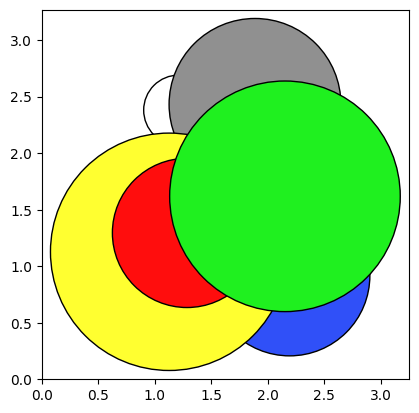

In [27]:
plot_atoms(Atoms(numbers=atoms_types, positions=np.random.rand(len(atoms_types), 3)*2), rotation="-0x,0y,0z")

# Convert to MoreRed inputs

### Examples from dataset

In [32]:
ids = []
for i, nums in tqdm(enumerate(numbers)):
    if 17 in nums:
        ids.append(i+1)

4003337it [00:33, 118494.97it/s]


In [33]:
random_ids = np.random.choice(ids, 8)

In [34]:
qm7x_examps = []

for i in random_ids:
    row = conn.get(id=int(i))
    qm7x_examps.append(row.toatoms())

In [35]:
[len(mol) for mol in qm7x_examps]

[11, 12, 13, 12, 11, 9, 9, 11]

In [ ]:
inputs = sampler.prepare_inputs(qm7x_examps)

### ClCCCl example

In [20]:
inputs = sampler.prepare_inputs(mols)#

In [21]:
priors = sampler.sample_prior(inputs, t=100)
inputs.update(priors)

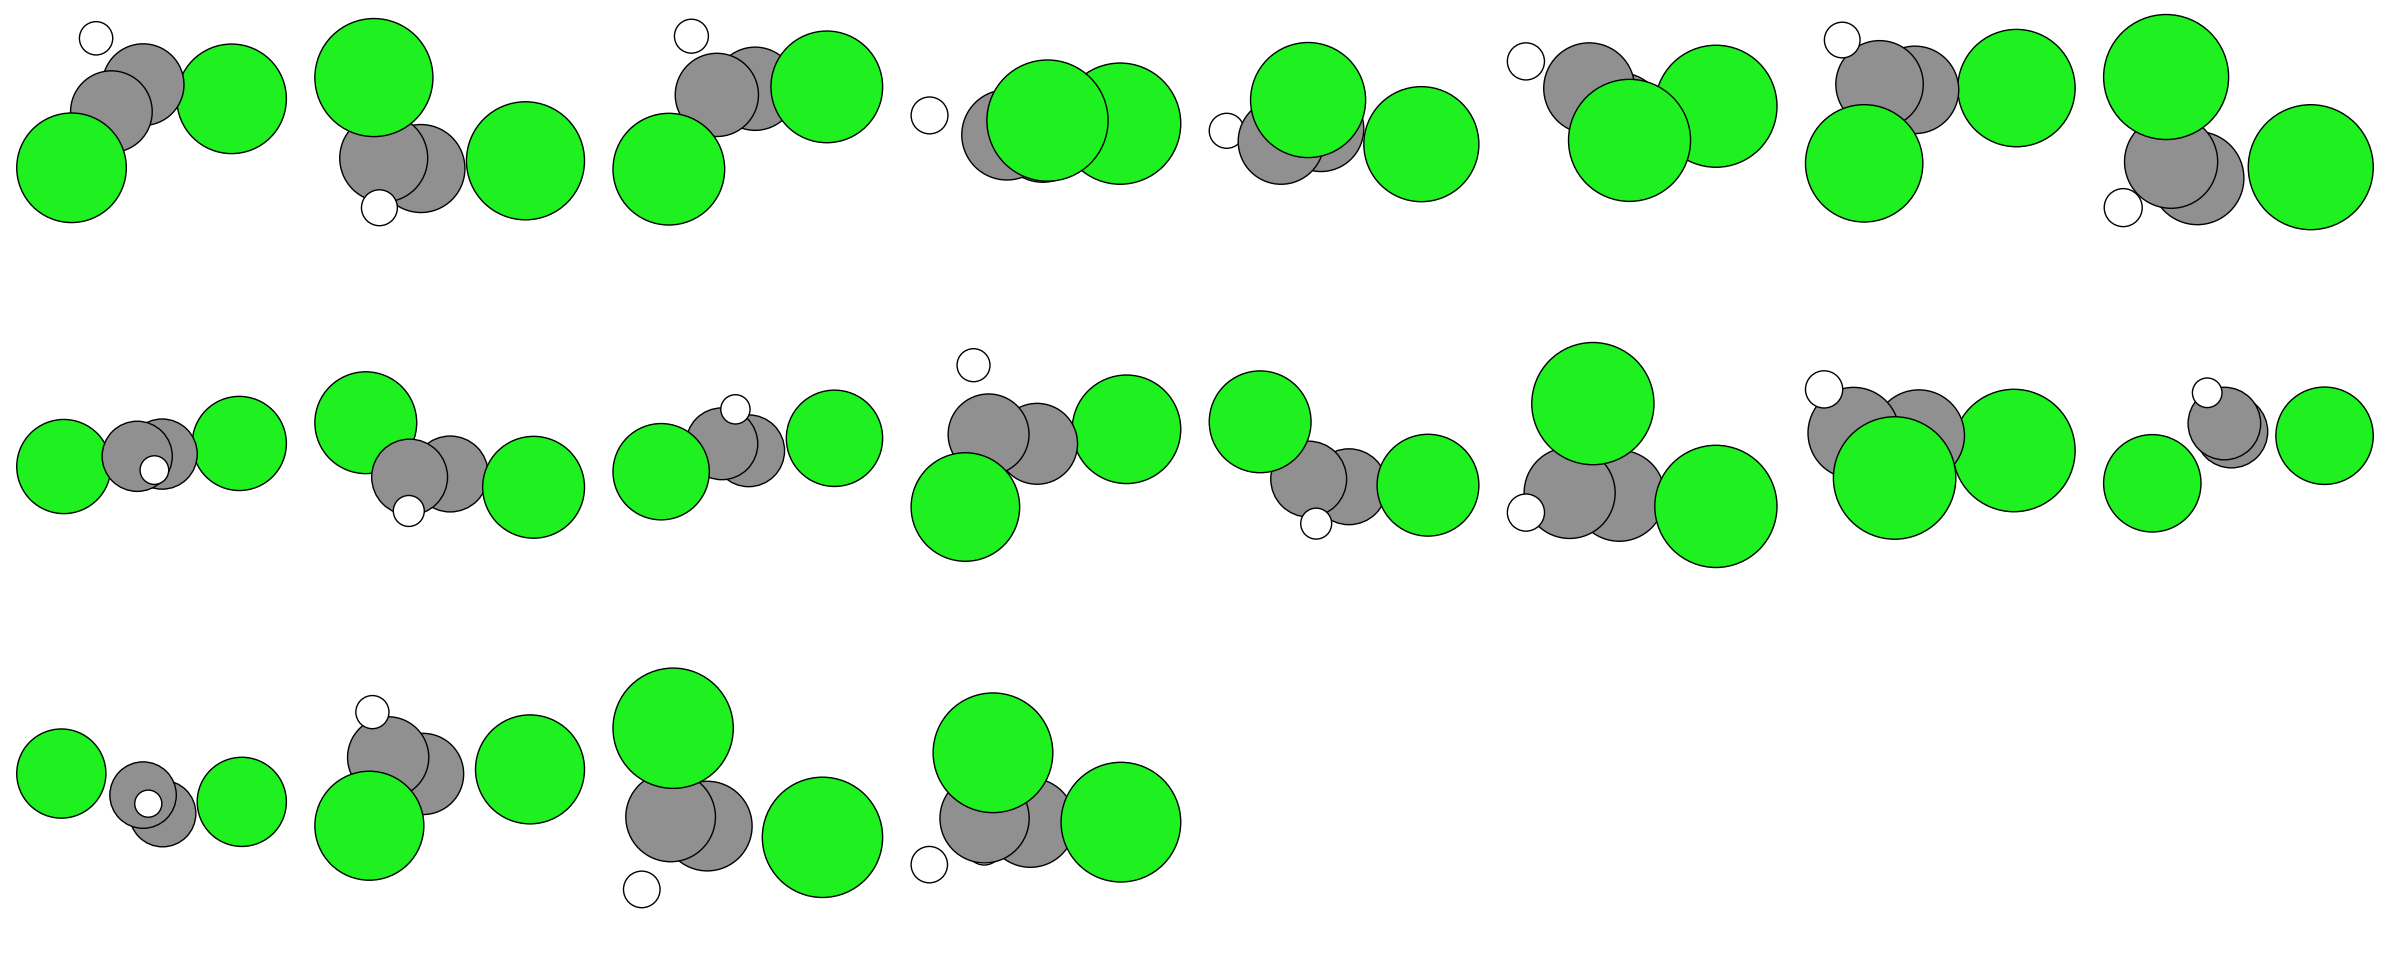

In [22]:
plot_batch_molecules(inputs)

# Denoise

In [23]:
relaxed, num_steps, hist = sampler.denoise(inputs, max_steps=800)
#relaxed, num_steps, hist = sampler.denoise(inputs, t=250)


# correct missing last step
hist.append({
    properties.R: relaxed[properties.R],
    "t": hist[-1]["t"],
})

269it [00:12, 20.72it/s]


In [24]:
inputs.update(relaxed)

In [25]:
num_steps

tensor([250, 223, 191, 170, 207, 199, 227, 216, 242, 220, 227, 232, 204, 205,
        232, 263, 269, 221, 237, 184])

In [26]:
t_preds = torch.vstack([h["t"] for h in hist]).T

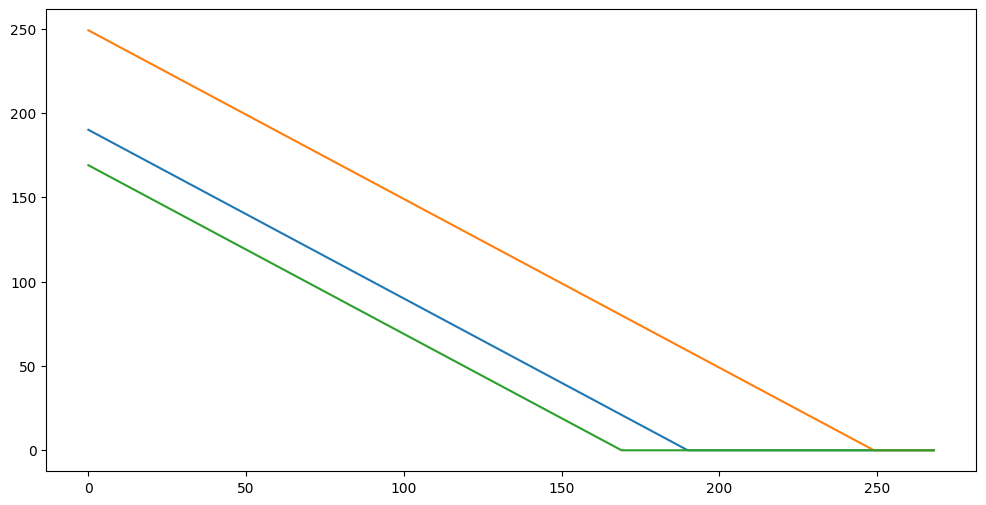

In [27]:
exmaps_t_preds = np.random.choice(len(t_preds), 3)
exmaps_t_preds = t_preds[exmaps_t_preds].detach().numpy()

plt.figure(figsize=(12, 6))
plt.plot(exmaps_t_preds.T)
plt.show()

In [28]:
relaxed_mols = [Atoms(numbers=inputs[properties.Z][inputs[properties.idx_m]==i], positions=relaxed[properties.R][inputs[properties.idx_m] == i]) for i in range(inputs[properties.idx_m].max() + 1)]
#relaxed_mols = [Atoms(numbers=mols[i].numbers, positions=relaxed[properties.R][inputs[properties.idx_m] == i]) for i in range(inputs[properties.idx_m].max() + 1)]

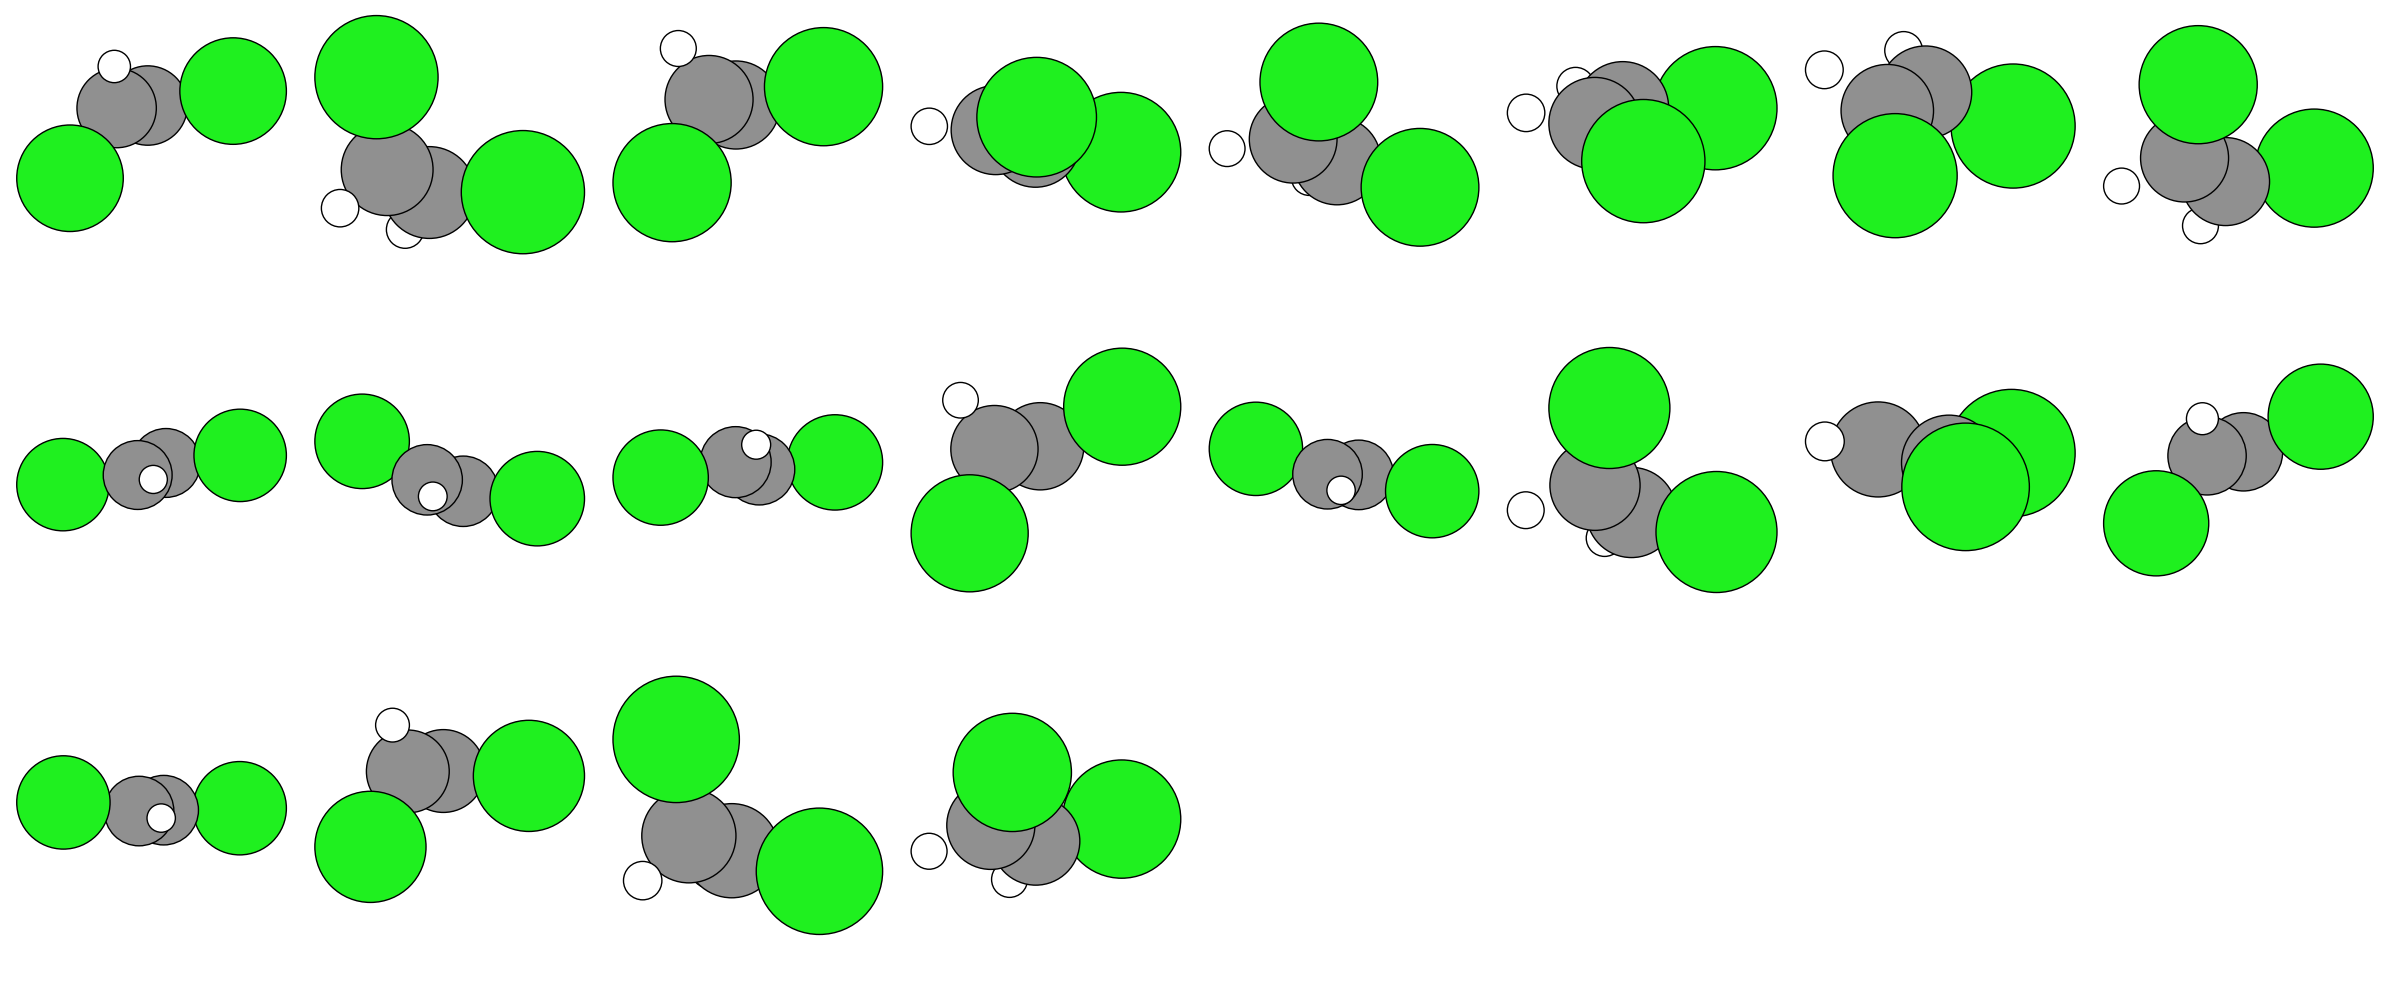

In [29]:
_ = plot_list_molecules(relaxed_mols, plot=True)

In [30]:
rmsds_mrd_0 = [rmsd(orig_conformers[0], mol, keep_original=True) for mol in relaxed_mols]
rmsds_mrd_1 = [rmsd(orig_conformers[1], mol, keep_original=True) for mol in relaxed_mols]
rmsds_mrd = np.min([rmsds_mrd_0, rmsds_mrd_1], axis=0)

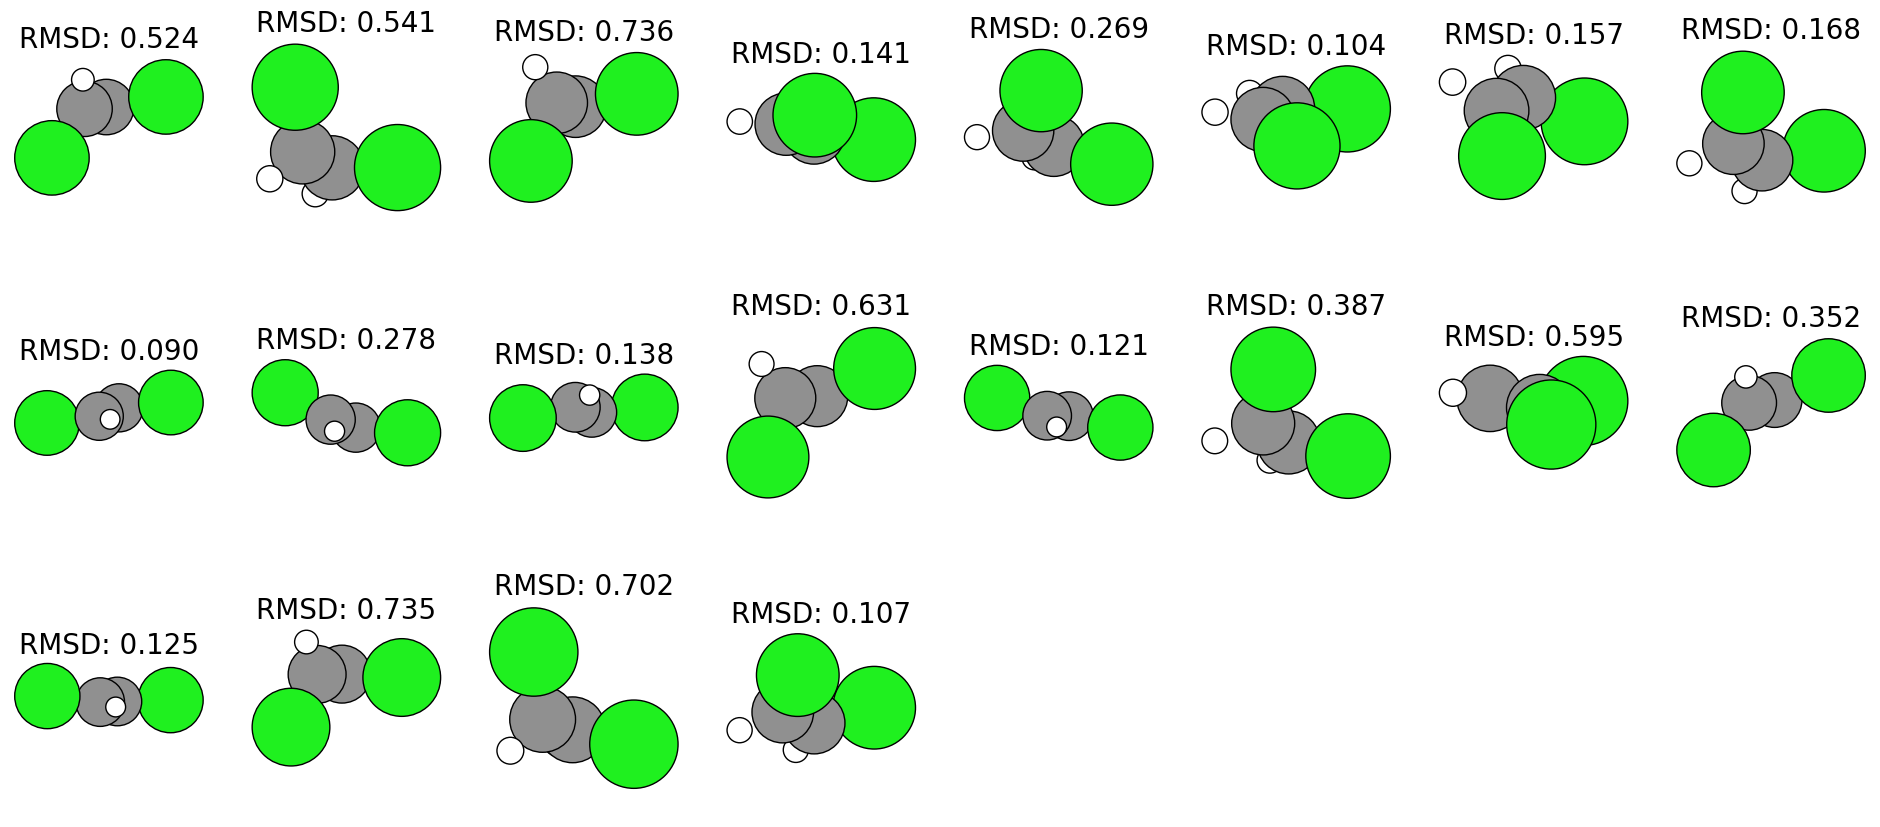

In [31]:
axs = plot_list_molecules(relaxed_mols, plot=False)

for i in range(len(rmsds_mrd)):
    axs[i].set_title(f"RMSD: {rmsds_mrd[i]:.3f}", fontsize=20)

In [80]:
num_steps

tensor([250, 223, 191, 170, 207, 199, 227, 216, 242, 220, 227, 232, 204, 205,
        232, 263, 269, 221, 237, 184])

In [87]:
trajs = []
for i, max_step in tqdm(enumerate(num_steps)):
    traj = []
    for j in range(max_step+1):
        j = j if j < len(hist) else -1
        traj.append(Atoms(numbers=inputs[properties.Z][inputs[properties.idx_m]==i], positions=hist[j][properties.R][inputs[properties.idx_m] == i]))
    
    trajs.append(traj)

20it [00:00, 43.52it/s]


In [97]:
for i in range(len(trajs)):
    ase.io.write(f"files/clcccl_relax/mrd_itp_100_clcccl_{i}.xyz", trajs[i])

In [93]:
(trajs[-1][-1].positions - relaxed_mols[-2].positions)

array([[ 0.49611077, -0.62410414,  0.95357829],
       [-0.07900423,  0.01870164, -0.01767358],
       [ 0.00380012, -0.01188691,  0.02089745],
       [ 0.06911337,  0.69965884, -0.65971896],
       [-0.39887071,  0.29557711, -0.47183871],
       [-0.09114845, -0.37794638,  0.1747551 ]])

In [67]:
hist[-1][properties.R][inputs[properties.idx_m] == 0] - hist[num_steps[0]][properties.R][inputs[properties.idx_m] == 0]

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [71]:
np.max(relaxed_mols[0].positions- hist[num_steps[0]-1][properties.R][inputs[properties.idx_m] == 0].numpy())

0.008864492177963257

In [95]:
list(zip([len(traj) for traj in trajs], num_steps))

[(251, tensor(250)),
 (224, tensor(223)),
 (192, tensor(191)),
 (171, tensor(170)),
 (208, tensor(207)),
 (200, tensor(199)),
 (228, tensor(227)),
 (217, tensor(216)),
 (243, tensor(242)),
 (221, tensor(220)),
 (228, tensor(227)),
 (233, tensor(232)),
 (205, tensor(204)),
 (206, tensor(205)),
 (233, tensor(232)),
 (264, tensor(263)),
 (270, tensor(269)),
 (222, tensor(221)),
 (238, tensor(237)),
 (185, tensor(184))]

In [77]:
ase.io.write("files/clcccl_relaxed.xyz", relaxed_mols)

In [233]:
view(relaxed_mols)

<Popen: returncode: None args: ['/home/twopaisquared/anaconda3/envs/morered/...>

In [183]:
validity = check_validity(inputs, *generate_bonds_data().values())
validity['stable_molecules'], validity['stable_molecules_wo_h']#, validity['connected'], validity['stable_atoms']

INFO:root:Bonds data already exists, skipping generation and reloading...
100%|██████████| 20/20 [00:00<00:00, 1767.06it/s]


([False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False],
 [False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False])

# MLFF  comparison

In [16]:
mlff_file = "/home/twopaisquared/Desktop/projects/UltraRed/experiments/diffusion/qm7x/split_2/qm7x_force_fields_b128_lr1e-4_n_at256_7327df54-6919-11ee-8e1d-ac1f6b2337dc/best_model"
mlff = torch.load(mlff_file, map_location="cpu")

In [17]:
transforms = [
    trn.SubtractCenterOfGeometry(),
    trn.MatScipyNeighborList(cutoff=5.),
    trn.CastTo32(),
]

force_th = 0.005
max_steps = 1000

In [18]:
calculator = SpkCalculator(
    model_file=mlff_file,
    converter=AtomsConverter,
    device=torch.device("cpu"),
    neighbor_list=None,
    transforms=transforms,
    energy_unit="eV",
    position_unit="Ang",
)

INFO:schnetpack.interfaces.ase_interface:Loading model from /home/twopaisquared/Desktop/projects/UltraRed/experiments/diffusion/qm7x/split_2/qm7x_force_fields_b128_lr1e-4_n_at256_7327df54-6919-11ee-8e1d-ac1f6b2337dc/best_model


In [27]:
mlff_relaxed = []

for i, mol in enumerate(mols):
    tmp_mol = mol.copy()
    tmp_mol.calc = calculator
    optimizer = LBFGS(tmp_mol, force_consistent=False, damping=0.7, trajectory=f"files/clcccl_relax/mlff/mlff_clcccl_{i}.traj")

    # optimize
    optimizer.run(steps=max_steps, fmax=force_th)

    mlff_relaxed.append(tmp_mol)

       Step     Time          Energy         fmax
LBFGS:    0 19:32:25   -27141.754923        0.9119


LBFGS:    1 19:32:25   -27141.779666        0.6892
LBFGS:    2 19:32:25   -27141.798754        0.3159
LBFGS:    3 19:32:25   -27141.807573        0.2996
LBFGS:    4 19:32:26   -27141.817459        0.3019
LBFGS:    5 19:32:26   -27141.830625        0.4265
LBFGS:    6 19:32:26   -27141.858034        0.6189
LBFGS:    7 19:32:26   -27141.930041        0.9723
LBFGS:    8 19:32:26   -27141.980913        1.4046
LBFGS:    9 19:32:26   -27142.022516        1.2759
LBFGS:   10 19:32:26   -27142.218310        0.8978
LBFGS:   11 19:32:26   -27142.251344        0.6536
LBFGS:   12 19:32:26   -27142.287198        0.7982
LBFGS:   13 19:32:26   -27142.328590        0.6744
LBFGS:   14 19:32:26   -27142.387509        0.7903
LBFGS:   15 19:32:26   -27142.442824        0.7219
LBFGS:   16 19:32:26   -27142.492747        0.5370
LBFGS:   17 19:32:26   -27142.525290        0.3914
LBFGS:   18 19:32:26   -27142.539580        0.2700
LBFGS:   19 19:32:26   -27142.546033        0.2148
LBFGS:   20 19:32:26   -27142.5

In [50]:
from ase.io.trajectory import Trajectory

trajs = []

mlff_relaxed_path = "files/clcccl_relax/mlff"

for file in [f for f in os.listdir(mlff_relaxed_path) if f.endswith(".traj")]:
    traj = Trajectory(f"{mlff_relaxed_path}/{file}")
    traj = [traj[i] for i in range(len(traj))]

    ase.io.write(f"{mlff_relaxed_path}/{file.replace("traj", "xyz")}", traj)

    # delete traj file
    os.remove(f"{mlff_relaxed_path}/{file}")

<Axes: >

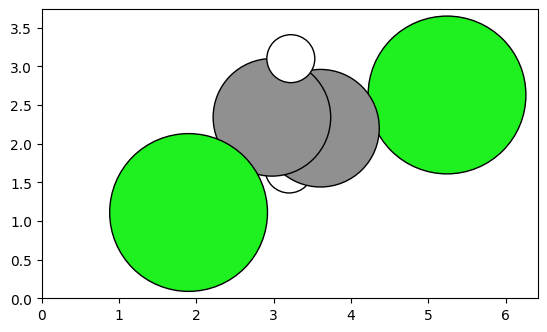

In [51]:
mols = ase.io.read("/home/twopaisquared/Desktop/projects/MoreRed/notebooks/files/clcccl_relax/mlff/mlff_clcccl_0.xyz", ":")
plot_atoms(mols[10], rotation="-0x,0y,0z")

In [36]:
mlff_rmsd_0 = [rmsd(orig_conformers[0], mol, keep_original=True) for mol in mlff_relaxed]
mlff_rmsd_1 = [rmsd(orig_conformers[1], mol, keep_original=True) for mol in mlff_relaxed]
mlff_rmsd = np.min([mlff_rmsd_0, mlff_rmsd_1], axis=0)

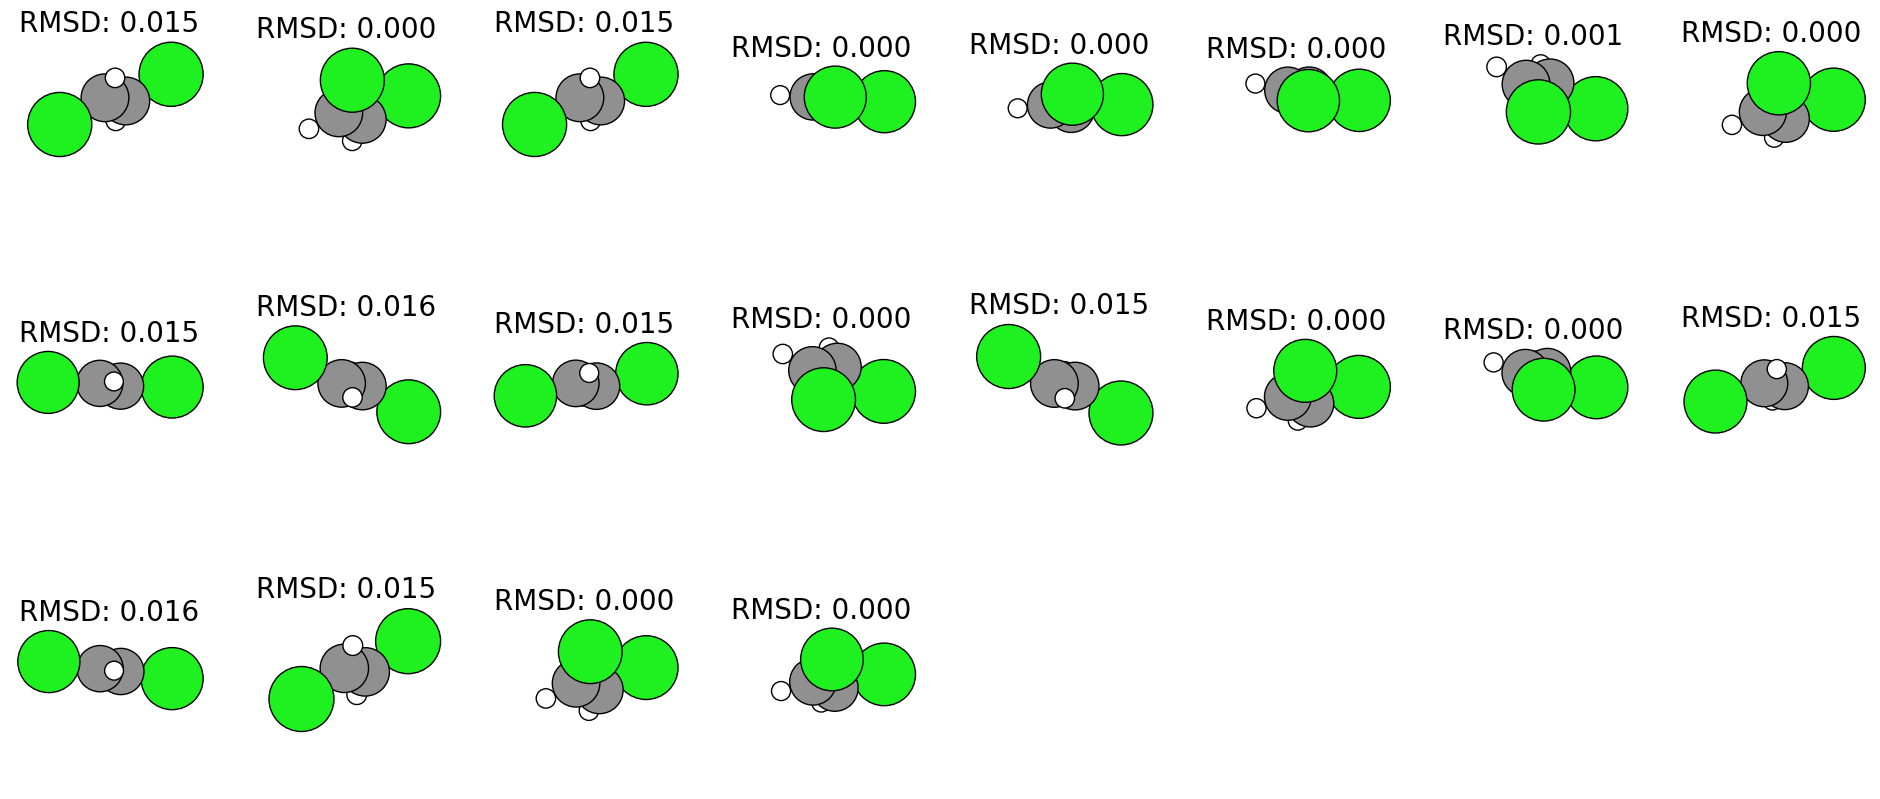

In [37]:
axs = plot_list_molecules(mlff_relaxed, plot=False)

for i in range(len(mlff_relaxed)):
    axs[i].set_title(f"RMSD: {mlff_rmsd[i]:.3f}", fontsize=20)

In [60]:
ase.io.write("/home/twopaisquared/Desktop/projects/UltraRed/experiments/diffusion/data/dichlorethene_rotamers/min_1.xyz", mlff_relaxed[1])

In [56]:
view(mlff_relaxed)

<Popen: returncode: None args: ['/home/twopaisquared/anaconda3/envs/morered/...>

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/twopaisquared/anaconda3/envs/morered/lib/python3.12/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/twopaisquared/anaconda3/envs/morered/lib/python3.12/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/home/twopaisquared/anaconda3/envs/morered/lib/python3.12/site-packages/matplotlib/pyplot.py", line 527, in show
    return _get_backend_mod().show(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/twopaisquared/anaconda3/envs/morered/lib/python3.12/site-packages/matplotlib_inline/backend_inline.py", line 90, in show
    display(
  File "/home/twopaisquared/anaconda3/envs/morered/lib/python3.12/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on closed file.
